<a href="https://colab.research.google.com/github/sandeepsign/beans-ai/blob/master/beans_entrance_point_detection_wip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!curl -s https://course.fast.ai/setup/colab | bash
!pip install nbconvert
!pip install fire
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

Updating fastai...
Done.
  Stored in directory: /root/.cache/pip/wheels/2a/1a/4d/6b30377c3051e76559d1185c1dbbfff15aed31f87acdd14c22
Successfully built fire
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
cd /content/gdrive/My\ Drive/fastai-v3/

/content/gdrive/My Drive/fastai-v3


In [0]:
#Check if label file is there
ls -lt entrance-detection-labels.csv

-rw------- 1 root root 11004 Jul  5 20:22 entrance-detection-labels.csv


## Regression with Entrance Images dataset

This is a example of how to create custom datasets and do regression with images. <br/>
**Our task is to find the approximate location point of the entrance in each building image.** <br/>

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
import pandas as pd
import matplotlib.pyplot as plt
import cv2

## Getting and converting the data

**THIS PART HAS TO BE DONE ONLY ONCE AFTER ANNOTATIONS!** MOVE TO NEXT SECTION IF DONE ALREADY, WHICH LOADS ALREADY PREPARED DATA.

The data set is created by Sandeep by manually capturing Google Maps 3D Images of the addresses provided by Krishna. We have converted the images to **png** format; though we might want to convert them to **jpeg**. 

In [0]:
ls -lt

total 531347
drwx------ 2 root root      4096 Jul  5 22:51 entrance-images/
-rw------- 1 root root      2356 Jul  5 22:48 entrance-xy.csv
-rw------- 1 root root     11004 Jul  5 20:22 entrance-detection-labels.csv
-rw------- 1 root root  91764236 Jul  5 19:06 biwi-stage-1.pth
-rw------- 1 root root 452316199 Nov  8  2018 biwi_head_pose.tgz


In [0]:
d1 = pd.read_csv(f'entrance-detection-labels.csv')

In [0]:
shape= d1.region_shape_attributes

In [0]:
d1.head()

,#filename,file_size,file_attributes,region_count,region_id,region_shape_attributes,region_attributes
0,1.png,1339428,{},1,0,"{""name"":""point"",""cx"":471,""cy"":649}",{}
1,2.png,1317266,{},1,0,"{""name"":""point"",""cx"":417,""cy"":543}",{}
2,3.png,1269741,{},1,0,"{""name"":""point"",""cx"":585,""cy"":455}",{}
3,4.png,1239502,{},1,0,"{""name"":""point"",""cx"":560,""cy"":466}",{}
4,5.png,1374267,{},1,0,"{""name"":""point"",""cx"":461,""cy"":620}",{}


In [0]:
d1['cx'] = d1.region_shape_attributes.map(lambda r: r.split('"cx":')[1].split(",")[0][:3])

In [0]:
d1['cy'] = d1.region_shape_attributes.map(lambda r: r.split('"cy":')[1].split(",")[0][:3])

In [0]:
d1.head()

,#filename,file_attributes,region_count,region_id,region_shape_attributes,region_attributes,cx,cy
0,1.png,{},1,0,"{""name"":""point"",""cx"":471,""cy"":649}",{},471,649
1,2.png,{},1,0,"{""name"":""point"",""cx"":417,""cy"":543}",{},417,543
2,3.png,{},1,0,"{""name"":""point"",""cx"":585,""cy"":455}",{},585,455
3,4.png,{},1,0,"{""name"":""point"",""cx"":560,""cy"":466}",{},560,466
4,5.png,{},1,0,"{""name"":""point"",""cx"":461,""cy"":620}",{},461,620


In [0]:
d1.drop(columns=['file_size','file_attributes','region_count','region_id','region_shape_attributes','region_attributes'],inplace=True)

In [0]:
d1.head()

,#filename,cx,cy
0,1.png,471,649
1,2.png,417,543
2,3.png,585,455
3,4.png,560,466
4,5.png,461,620


In [0]:
#save csv file to be used in model 
d1.to_csv("entrance-xy.csv", index=False, encoding='utf8')

In [0]:
ls -lt entrance-xy.csv

-rw------- 1 root root 2356 Jul  5 22:48 entrance-xy.csv


# Restore from already prepared label file

In [0]:
d1 = pd.read_csv(f'entrance-xy.csv')

In [0]:
img_path = f'{base_dir}/entrance-images'
fname = f'{img_path}/1.png'

In [0]:
#Read the entrance location x and y as tuple by passing image file name
## EXAMPLE: img2ctr('1.png')
## RETURNS: (471, 649)
def img2ctr(f): 
  if not isinstance(f, str): 
    f=str(f).split('/')[-1]
  return (d1[d1['#filename']==f]['cx'].to_numpy()[0], d1[d1['#filename']==f]['cy'].to_numpy()[0])

def img2ctr_tensor(f):
  return torch.tensor(img2ctr(f)).float()

#Put red dot to indicate entrance in image matrix data
## EXAMPLE: cate_entrance(img_nparray, loc_tuple)
def indicate_entrance(img, xy_tuple):
  return cv2.circle(img,(to_int(xy_tuple[0]),to_int(xy_tuple[1])), 10, (255,0,0), -1)

In [0]:
img2ctr('1.png')

(471, 649)

In [0]:
def show_image_with_entrance(image_file):
  #get x,y from image name
  loc = img2ctr(image_file)
  #read image object matrix
  img_file_path = f'{img_path}/{image_file}'
  img = open_image(img_file_path)
  #Transpose image object for cv2 : fastai img -> Pytorch Tensor -> Numpy Array -> Transpose
  npt_im = img.data.numpy().transpose(1,2,0)
  #Put the entrance indicator in image
  npt_im = indicate_entrance(npt_im, loc)
  #display image
  plt.figure()
  plt.imshow(npt_im)
  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


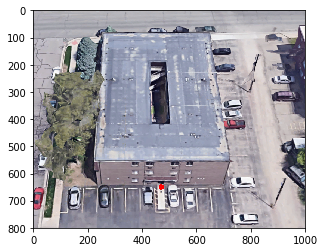

In [0]:
show_image_with_entrance('1.png')

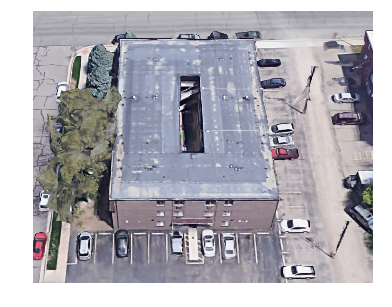

In [0]:
# FastAI way of introspecting image without entrance
img = open_image(fname)
img.show(figsize=(7,5))

## Creating a dataset

In [0]:
imagenet_stats

([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [0]:
path = Path(img_path)
path.parent.name

'fastai-v3'

In [0]:
o = PointsItemList.from_folder(path)

In [0]:
o2 = o.split_by_rand_pct()

In [0]:
print(o2.valid.items.shape)

(30,)


In [0]:
o3 = o2.label_from_func(img2ctr_tensor)

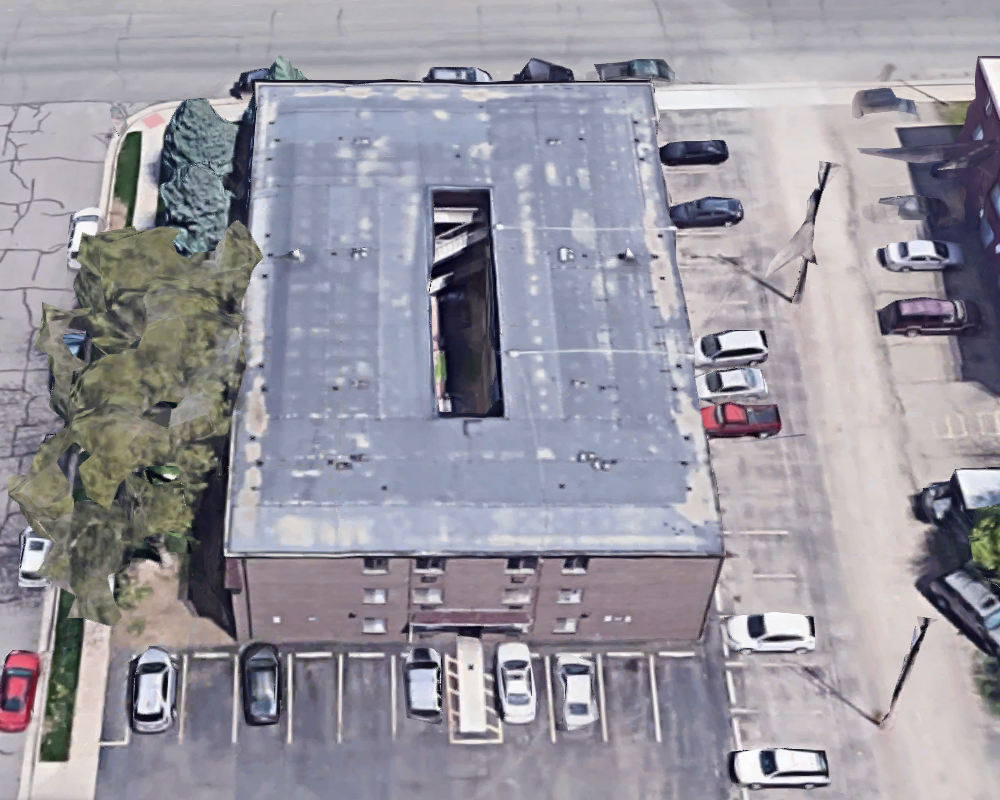

In [0]:
#img_path
open_image(f'{img_path}/1.png')

In [0]:
dt = img.data
#for i in range(1,150):
#  if open_image(f'{img_path}/{i}.png').data.max().item() > 1.0:
#    print(i)

In [0]:
o3.transform(get_transforms(), tfm_y=True, size=(120,160))

LabelLists;

Train: LabelList (123 items)
x: PointsItemList
Image (3, 120, 160),Image (3, 120, 160),Image (3, 120, 160),Image (3, 120, 160),Image (3, 120, 160)
y: PointsLabelList
ImagePoints (120, 160),ImagePoints (120, 160),ImagePoints (120, 160),ImagePoints (120, 160),ImagePoints (120, 160)
Path: /content/gdrive/My Drive/fastai-v3/entrance-images;

Valid: LabelList (30 items)
x: PointsItemList
Image (3, 120, 160),Image (3, 120, 160),Image (3, 120, 160),Image (3, 120, 160),Image (3, 120, 160)
y: PointsLabelList
ImagePoints (120, 160),ImagePoints (120, 160),ImagePoints (120, 160),ImagePoints (120, 160),ImagePoints (120, 160)
Path: /content/gdrive/My Drive/fastai-v3/entrance-images;

Test: None

In [0]:
data = (PointsItemList.from_folder(path)
        .split_by_rand_pct()
        .label_from_func(img2ctr_tensor)
        .transform(get_transforms(), tfm_y=True, size=(120,160))
        .databunch().normalize(imagenet_stats)
       )

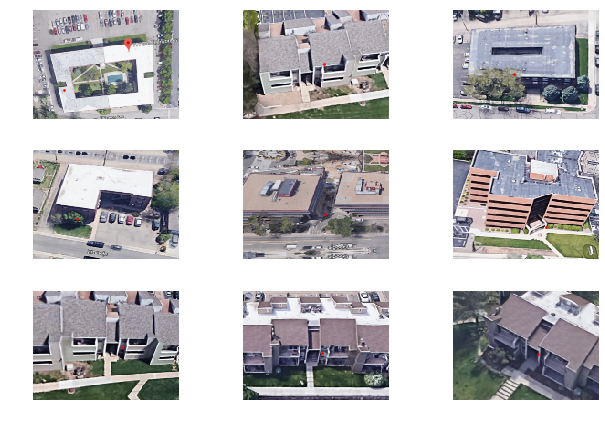

In [0]:
data.show_batch(3, figsize=(9,6))

## Train model

In [0]:
learn = cnn_learner(data, models.resnet34)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:00<00:00, 111056561.91it/s]


In [0]:
learn.lr_find()
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


RuntimeError: ignored

In [0]:
lr = 2e-2

In [0]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,time
0,1.486881,#na#,00:04
1,1.550825,#na#,00:04
2,1.673079,#na#,00:04
3,1.602126,#na#,00:04
4,1.423005,#na#,00:04


In [0]:
learn.save(f'{base_dir}/beans-EP-stage-1')

In [0]:
!du -h beans-EP-stage-1.pth

88M	beans-EP-stage-1.pth


In [0]:
learn.load(f'{base_dir}/beans-EP-stage-1')

In [0]:
learn.show_results()

IndexError: ignored

## Data augmentation

In [0]:
tfms = get_transforms(max_rotate=20, max_zoom=1.5, max_lighting=0.5, max_warp=0.4, p_affine=1., p_lighting=1.)

data = (PointsItemList.from_folder(path)
        .split_by_valid_func(lambda o: o.parent.name=='13')
        .label_from_func(get_ctr)
        .transform(tfms, tfm_y=True, size=(120,160))
        .databunch().normalize(imagenet_stats)
       )

You can deactivate this warning by passing `no_check=True`.


/usr/local/lib/python3.6/dist-packages/fastai/basic_data.py:269: UserWarning: It's not possible to collate samples of your dataset together in a batch.
Shapes of the inputs/targets:
[[torch.Size([3, 120, 160]), torch.Size([3, 120, 160]), torch.Size([3, 120, 160]), torch.Size([3, 120, 160]), torch.Size([3, 120, 160]), torch.Size([3, 120, 160]), torch.Size([3, 120, 160]), torch.Size([3, 120, 160]), torch.Size([3, 120, 160]), torch.Size([3, 120, 160]), torch.Size([3, 120, 160]), torch.Size([3, 120, 160]), torch.Size([3, 120, 160]), torch.Size([3, 120, 160]), torch.Size([3, 120, 160]), torch.Size([3, 120, 160]), torch.Size([3, 120, 160]), torch.Size([3, 120, 160]), torch.Size([3, 120, 160]), torch.Size([3, 120, 160]), torch.Size([3, 120, 160]), torch.Size([3, 120, 160]), torch.Size([3, 120, 160]), torch.Size([3, 120, 160]), torch.Size([3, 120, 160]), torch.Size([3, 120, 160]), torch.Size([3, 120, 160]), torch.Size([3, 120, 160]), torch.Size([3, 120, 160]), torch.Size([3, 120, 160]), torch.

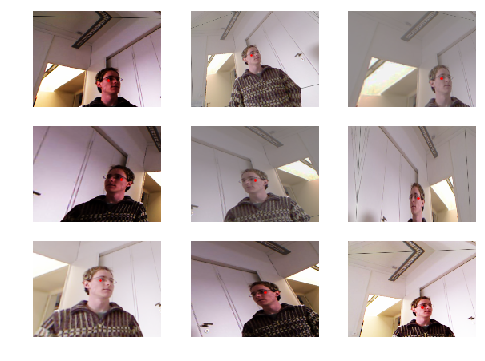

In [0]:
def _plot(i,j,ax):
    x,y = data.train_ds[0]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,6))